In [34]:
import signVerify
import hashlib
import DataBaseConection
from CertificateFunctions import cert_gen, check_associate_cert_with_private_key, VerificarVigencia, Hash_document, VerificarPassword

In [35]:
database = DataBaseConection.DataBase(user = "root", password = "", db = "teleton")

Conexión exitosa


# Ejemplo de uso del sistema

## Creando usuarios

### Creando certificados

In [36]:
nombre_1 = "Jairo Enrique R"
password_1 = "prueba"
nomina_1 = "A01750442"
email_1 = "A01750442@tec.mx"

nombre_2 = "Ramirez Sanchez R"
nomina_2 = "A01752067"
password_2 = "prueba2"
email_2 = "A01752067@tec.mx"


cert_gen(emailAddress=email_1,
    commonName=nomina_1,
    countryName="MX",
    localityName="Monterrey",
    stateOrProvinceName="Nuevo León",
    organizationName="Tecnológico de Monterrey",
    organizationUnitName="organizationUnitName",
    serialNumber=0,
    validityStartInSeconds = 0,
    validityEndInSeconds = 1*365*24*60*60, #UN AÑO
    KEY_FILE = "Ejemplo/private"+nomina_1.replace(" ","_")+".key",
    CERT_FILE="Ejemplo/Certificado"+nomina_1.replace(" ","_")+".crt")

cert_gen(emailAddress=email_2,
    commonName=nomina_2,
    countryName="MX",
    localityName="Monterrey",
    stateOrProvinceName="Nuevo León",
    organizationName="Tecnológico de Monterrey",
    organizationUnitName="organizationUnitName",
    serialNumber=0,
    validityStartInSeconds = 0,
    validityEndInSeconds = 1*365*24*60*60, #UN AÑO
    KEY_FILE = "Ejemplo/private"+nomina_2.replace(" ","_")+".key",
    CERT_FILE="Ejemplo/Certificado"+nomina_2.replace(" ","_")+".crt")

print("Firmas generadas")
print("Guarde su llave privada en un lugar aparte")
print("-------------------\n")
print("Subiendo certificado a la base de datos")

database.insert_users(nomina = nomina_1,
                password=hashlib.sha256(bytes(password_1, encoding="utf-8")).hexdigest(),
                nombre = nombre_1,
                puesto = "Estudiante",
                tags = "IDM",
                certificado = f"Ejemplo/Certificado{nomina_1}.crt",
                estatus = "Activo")

database.insert_users(nomina = nomina_2,
                password = hashlib.sha256(bytes(password_2, encoding="utf-8")).hexdigest(),
                nombre = nombre_2,
                puesto = "Estudiante",
                tags = "IDM",
                certificado = f"Ejemplo/Certificado{nomina_2}.crt",
                estatus = "Activo")

Firmas generadas
Guarde su llave privada en un lugar aparte
-------------------

Subiendo certificado a la base de datos
Jairo Enrique R ha sido añadido a la base de datos.
Ramirez Sanchez R ha sido añadido a la base de datos.


## Solicitar firma

In [27]:
#Primero se sube el documento que se quiere firmar con todos los datos de indentificación
file_1 = "Ejemplo/Doc_2.pdf"

database.insert_documentos(Hash = Hash_document(file_1).hexdigest(), 
                           Tipo = "Libro", 
                           Nombre = "Doc_1.pdf", 
                           Descripcion = "Justine o los infortunios de la virtud",
                           Tags = f"{nomina_1};{nomina_2}",
                           Estatus = "Activo")


Doc_1.pdf ha sido añadido a la base de datos.


In [69]:
file_1 = "Ejemplo/Doc_1.pdf"
Hash_document(file_1).hexdigest()

'50df68716b0074ebd4e5f2ccb5b378d89a8a174128394a57654d4410d4a268e5'

In [94]:
users = database.select(tabla = "documentos", 
                what = "Tags", 
                where = "hash", 
                value = "e3b0c44298fc1c149afbf4c8996fb92427ae41e4")

nomina = "A01750442"
#nomina in 
users#[0][0].split(";")

()

## Generar el archivo firmado

In [31]:
# Obtiene el certificado de la base de datos del usuario tomando su nómina
file_1 = "Ejemplo/Doc_1.pdf"
Certificado_1 = database.select(tabla = "users", 
                what = "Certificado", 
                where = "Nomina", 
                value = nomina_1)[0][0]

# Se carga la llave privada del usuario

private_key_1 = "Ejemplo/privateA01750442.key"

#Se verifica la vigencia para saber si es posible firmar el documento

VerificarVigencia(Certificado_1)

#Se valida si la llave privada coincide con el certificado almacenado, es decir, que quien quiera firmar sea quien dice ser.

Match = check_associate_cert_with_private_key(Certificado_1, private_key_1)
print()

if Match:
    # se generar el archivo de firma digital
    file_name = signVerify.gen_signature(private_key_1, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), file_1, nomina_1)
    print(f"Archivo firmado en {file_name}")

    print("\n Cargando la firma a la base de datos")
    database.cargar_firma(Doc_signed = file_name,
                     Hash = Hash_document(file_1).hexdigest(),
                     Nomina = nomina_1)
    database.insert_firma(Doc_signed = file_name,
                             Hash = Hash_document(file_1).hexdigest(),
                             Nomina = nomina_1)
else:
    print("La llave privada no coincide con el certificado.\nNo puede firmar este documento.")

print("\n-------------------------------\n")

Certificado_2 = database.select(tabla = "users", 
                what = "Certificado", 
                where = "Nomina", 
                value = nomina_2)[0][0]

private_key_2 = "Ejemplo/privateA01752067.key"

VerificarVigencia(Certificado_2)

Match = check_associate_cert_with_private_key(Certificado_2, private_key_2)

if Match:

    file_name = signVerify.gen_signature(private_key_2, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), file_1, nomina_2)
    print(f"Archivo firmado en {file_name}")

    print("\n Cargando la firma a la base de datos")
    database.cargar_firma(Doc_signed = file_name,
                     Hash = Hash_document(file_1).hexdigest(),
                     Nomina = nomina_2)
else:
    print("La llave privada no coincide con el certificado.\nNo puede firmar este documento.")

Certificado vigente

Archivo firmado en Ejemplo/Doc_1.pdf_A01750442_20220427_214230.sign

 Cargando la firma a la base de datos
50df68716b0074ebd4e5f2ccb5b378d89a8a174128394a57654d4410d4a268e5 ha sido añadido a la base de datos.

-------------------------------

Certificado vigente
Archivo firmado en Ejemplo/Doc_1.pdf_A01752067_20220427_214231.sign

 Cargando la firma a la base de datos


In [29]:
from OpenSSL import crypto  
crtObj = crypto.load_certificate(crypto.FILETYPE_PEM, open("Ejemplo/CertificadoA01750442.crt").read())
type(crtObj.get_subject())
crtObj.get_subject().commonName

'A01750442'

## Verificar firma

In [32]:
from OpenSSL import crypto  
# Es cargado el documento a verificar
file_1 = "Ejemplo/Doc_1.pdf"
file_2 = "Ejemplo/Doc_2.pdf"

#Se emula que se suben los certificados

#Se cargan los certificados de las personas que se quieren validar
Certificado_1 = "Ejemplo/CertificadoA01750442.crt"

nomina_1 = crypto.load_certificate(crypto.FILETYPE_PEM, open(Certificado_1).read()).get_subject().commonName


# Se extraé de la base de datos el archivo firmado que coincida con el hash del documento y la nómina
f = database.select(tabla = "firmas", 
                what = "Doc_signed", 
                where = "Hash", 
                value = Hash_document(file_1).hexdigest(),
                where_2 = "Nomina",
                value_2 = nomina_1)[0][0]

if f != None:
    # Si el archvio existe, se valida la firma
    open("Ejemplo/temp.sign", "wb").write(f)

    result = signVerify.verify(Certificado_1, bytes(Hash_document(file_1).hexdigest(), 'utf-8'), "Ejemplo/temp.sign", load = True)
    if result:
        print(f"Verificación exitosa. \nEl archivo fue firmado correctamente por {nomina_1}")
    else:
        print(f"Verificación fallida. \nEl archivo no firmado por {nomina_1}")

else:
    # Si el archivo aún no existe, tiene pendiente la firma
    print(f"El archivo aún no cuenta con la firma de {nomina_1}")


Verificación exitosa. 
El archivo fue firmado correctamente por A01750442


In [56]:
VerificarPassword("A01750442", "prueba", database)

True

In [8]:
import matplotlib.pyplot as plt

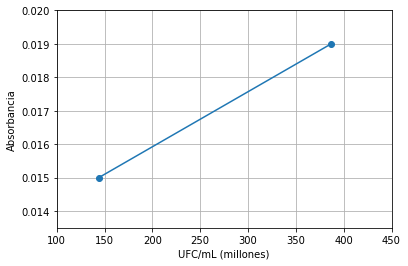

In [31]:
plt.plot([144, 387], [0.015, 0.019], marker="o")
plt.grid()
plt.xlabel(r"UFC/mL (millones)")
plt.ylabel("Absorbancia")
plt.title("")
plt.xlim([100, 450])
plt.ylim([0.0135, 0.02])
plt.show()


## Pruebas de rendimiento

In [77]:
from cryptography.hazmat.primitives import hashes

from OpenSSL import crypto, SSL
from datetime import datetime
import OpenSSL.crypto 
import sys
import hashlib

from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding
from OpenSSL import crypto  


def gen_signature(priv_key, document, nombreDoc, nomina,hsh):
    """
    :type priv_key: str (dirección del documento)
    :type document: bytes (El hash pasarlo a str y eso a bytes)
    :type nombreDoc: str (nombre del archivo a firmar, solo como referencia)
    :type nomina: str (nomina de quien firma)
    :rtype: str (nombre del archivo firmado)
    """
    '''Receives the HASH of the documentPDF and the private key,
    returns a binary file with the signature.
    This will be uploaded to the logs section FIRMAS'''

    #Read private_key from other file
    with open(priv_key, "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(),
            password=None,
        )
    signature = private_key.sign(
        document,
        padding.PSS(
            mgf=padding.MGF1(hsh),     
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hsh
    )   

    #Format: aaaammdd_hhmmss
    date = str(datetime.now()).replace('-', '').replace(':', '').replace(' ', '_')[:-7]

    #write the binary signature file
    name = f"{nombreDoc}_{nomina}_{date}.sign"
    f = open(name, "wb")
    f.write(signature)
    f.close()

    #Returns the sign binary file, will be uploaded to DB
    return name


## Verifying Algorithm
def verify(cert, document, sigfile, hsh, load = True):
    """
    :type cert: str (dirección del documento)
    :type document: bytes (El hash pasarlo a str y eso a bytes)
    :type sigfile: str (Dirección del archivo firmado)
    :type load: bool (Saber si lo tiene que leer del disco [True] o se le pasará un archivo en bytes)
    :rtype: str (nombre del archivo firmado)
    """
    '''Receives the certificate with public key, the
    document and the signaturefile to see if said signatures
    corresponds to that document. And its hasn't been 
    altered or something else was signed. '''

    #Get public_key from certificate
    
    
    if load:
        f = open(sigfile, 'rb')
        sigfile = f.read()
        crtObj = crypto.load_certificate(crypto.FILETYPE_PEM, open(cert).read())
    else:
        crtObj = crypto.load_certificate(crypto.FILETYPE_PEM, cert)
        
    pub_key = crtObj.get_pubkey()
    pub_key = pub_key.to_cryptography_key()

    try: 
        pub_key.verify(
        sigfile,
        document,
        padding.PSS(
            mgf=padding.MGF1(hsh),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hsh
        )
        return True

    except: 
        return False

def cert_gen(
    emailAddress="emailAddress",
    commonName="commonName",
    countryName="NT",
    localityName="localityName",
    stateOrProvinceName="stateOrProvinceName",
    organizationName="organizationName",
    organizationUnitName="organizationUnitName",
    serialNumber=0,
    validityStartInSeconds=0,
    validityEndInSeconds=10*365*24*60*60,
    KEY_FILE = "private.key",
    CERT_FILE="selfsigned.crt",
    hsh = "sha256"):
    #can look at generated file using openssl:
    #openssl x509 -inform pem -in selfsigned.crt -noout -text
    # create a key pair
    k = crypto.PKey()
    k.generate_key(crypto.TYPE_RSA, 4096)
    # create a self-signed cert
    cert = crypto.X509()
    cert.get_subject().C = countryName
    cert.get_subject().ST = stateOrProvinceName
    cert.get_subject().L = localityName
    cert.get_subject().O = organizationName
    cert.get_subject().OU = organizationUnitName
    cert.get_subject().CN = commonName
    cert.get_subject().emailAddress = emailAddress
    cert.set_serial_number(serialNumber)
    cert.gmtime_adj_notBefore(0)
    cert.gmtime_adj_notAfter(validityEndInSeconds)
    cert.set_issuer(cert.get_subject())
    cert.set_pubkey(k)
    cert.sign(k, hsh)
    with open(CERT_FILE, "wt") as f:
        f.write(crypto.dump_certificate(crypto.FILETYPE_PEM, cert).decode("utf-8"))
    with open(KEY_FILE, "wt") as f:
        f.write(crypto.dump_privatekey(crypto.FILETYPE_PEM, k).decode("utf-8"))
        
def Hash_document(file, sha1):
    """
    :type file: str (dirección del archivo)
    :rtype: _hashlib.HASH
    Utilice Hash_document(file).hexdigest() para obtener la representación del SHA en string.
    """
    # BUF_SIZE is totally arbitrary, change for your app!
    BUF_SIZE = 65536  # lets read stuff in 64kb chunks!
    #hashlib.sha512

    with open(file, 'rb') as f:
        while True:
            data = f.read(BUF_SIZE)
            if not data:
                break
            sha1.update(data)

    return sha1

In [9]:
Resultados#["sha1"]["cert"].append(1001)

{'sha1': {'cert': [10, 1001], 'gen': [], 'ver': []},
 'sha224': {'cert': [], 'gen': [], 'ver': []},
 'sha256': {'cert': [], 'gen': [], 'ver': []},
 'sha512': {'cert': [], 'gen': [], 'ver': []},
 'sha384': {'cert': [], 'gen': [], 'ver': []}}

In [3]:
Resultados = {i[2]:{"cert":[], "gen":[], "ver":[]} for i in P}

In [85]:
import time
import progressbar

file = "PruebasRendimiento/Doc1.pdf"
P = [[hashes.SHA1(), hashlib.sha1(),"sha1"], 
         [hashes.SHA224(), hashlib.sha224(), "sha224"], 
         [hashes.SHA256(), hashlib.sha256(), "sha256"], 
         [hashes.SHA512(), hashlib.sha512(), "sha512"],
         [hashes.SHA384(), hashlib.sha384(), "sha384"],
        ]

#Resultados = {i[2]:{"cert":[], "gen":[], "ver":[]} for i in P}
for _ in progressbar.progressbar(range(400)):
    for h, j, k in P:
        #print("---------------------------------------------------")
        #print(f"{k}")
        start_time = time.time()

        cert_gen(emailAddress="email_1",
            commonName="tec.mx",
            countryName="MX",
            localityName="Monterrey",
            stateOrProvinceName="Nuevo León",
            organizationName="Tecnológico de Monterrey",
            organizationUnitName="organizationUnitName",
            serialNumber=0,
            validityStartInSeconds = 0,
            validityEndInSeconds = 1*365*24*60*60, #UN AÑO
            KEY_FILE = "PruebasRendimiento/private.key",
            CERT_FILE="PruebasRendimiento/Certificado.crt",
            hsh = k)
        #print(f"Tiempo en generar claves: {(time.time() - start_time)}")

        Resultados[k]["cert"].append(time.time() - start_time)

        start_time = time.time()
        d = gen_signature("PruebasRendimiento/private.key", 
                      bytes(Hash_document(file, j).hexdigest(), 'utf-8'), file, "a01750443", h)
        #print(f"Tiempo en generar firma: {(time.time() - start_time)}")
        Resultados[k]["gen"].append(time.time() - start_time)

        start_time = time.time()
        verify("PruebasRendimiento/Certificado.crt", bytes(Hash_document(file, j).hexdigest(), 'utf-8'), d, h, load = True)
        #print(f"Tiempo en verificar firma: {(time.time() - start_time)}")
        Resultados[k]["ver"].append(time.time() - start_time)
        #print("---------------------------------------------------")
        #print()

100% (400 of 400) |######################| Elapsed Time: 6:41:23 Time:  6:41:23


In [17]:
Resultados_std = {i[2]:{"cert":0, "gen":0, "ver":0} for i in P}
Resultados_medias = {i[2]:{"cert":0, "gen":0, "ver":0} for i in P}

for k in Resultados.keys():
    for j in Resultados[k].keys():
        Resultados_medias[k][j] = np.mean(Resultados[k][j])
        Resultados_std[k][j] = np.std(Resultados[k][j])

In [23]:
import pandas as pd
Data_std = pd.DataFrame.from_dict(Resultados_std)
Data_std = (Data_std)[["sha1", "sha224","sha256","sha384","sha512"]].T
Data_std

,cert,gen,ver
sha1,0.265085,0.008305,0.004249
sha224,0.371484,0.018237,0.006134
sha256,0.394543,0.006953,0.004703
sha384,0.367612,0.007007,0.005115
sha512,0.342995,0.007834,0.007466


In [19]:
import pandas as pd
Data = pd.DataFrame.from_dict(Resultados_medias)
Data = (Data)[["sha1", "sha224","sha256","sha384","sha512"]].T
Data

,cert,gen,ver
sha1,0.480466,0.037665,0.011777
sha224,0.508750,0.038971,0.012134
sha256,0.604306,0.036766,0.011663
sha384,0.442196,0.038043,0.012594
sha512,0.508876,0.039257,0.013076


In [35]:
import matplotlib.pyplot as plt
from pylab import *

<ipython-input-71-43bfe7b675a4>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])


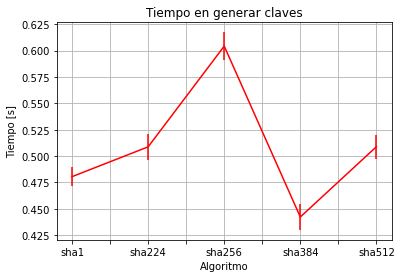

In [71]:
axes = figure().add_subplot(111)
plt.errorbar(np.arange(Data.cert.shape[0]), np.array(Data.cert), Data_std.cert/30, color = "red", label="error")

a=axes.get_xticks().tolist()
axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])


#plt.plot(Data.gen, marker="x")
plt.grid()
plt.title("Tiempo en generar claves")
plt.xlabel("Algoritmo")
plt.ylabel("Tiempo [s]")
#plt.errorbar(Data.cert, Data.index, Data_std.cert)
plt.show()


<ipython-input-70-e7fc964f80ab>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])


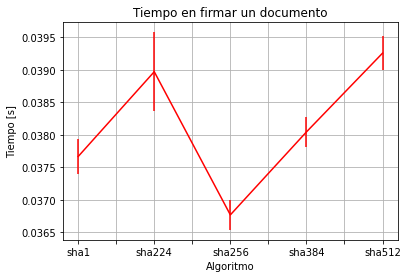

In [70]:
axes = figure().add_subplot(111)
plt.errorbar(np.arange(Data.gen.shape[0]), np.array(Data.gen), Data_std.gen/30, color = "red", label="error")

a=axes.get_xticks().tolist()
axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])


plt.grid()
plt.title("Tiempo en firmar un documento")
plt.xlabel("Algoritmo")
plt.ylabel("Tiempo [s]")
plt.show()

<ipython-input-69-e97b284727ef>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])


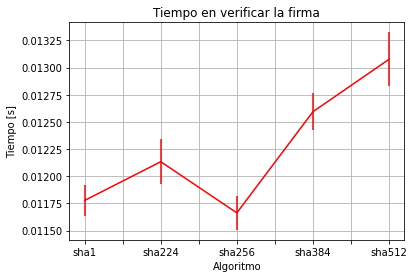

In [69]:
axes = figure().add_subplot(111)
plt.errorbar(np.arange(Data.ver.shape[0]), np.array(Data.ver), Data_std.ver/30, color = "red", label="error")

a=axes.get_xticks().tolist()
axes.set_xticklabels(['','sha1','' ,'sha224','', 'sha256','', 'sha384','', 'sha512'])

plt.grid()
plt.title("Tiempo en verificar la firma")
plt.xlabel("Algoritmo")
plt.ylabel("Tiempo [s]")
plt.show()

(array([ 3.,  2.,  1.,  2., 47., 10., 11.,  5., 15.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01560783, 0.01932741, 0.02304699, 0.02676657, 0.03048615,
        0.03420573, 0.03792531, 0.0416449 , 0.04536448, 0.04908406,
        0.05280364, 0.05652322, 0.0602428 , 0.06396238, 0.06768196,
        0.07140154, 0.07512112, 0.0788407 , 0.08256028, 0.08627986,
        0.08999944]),
 <BarContainer object of 20 artists>)

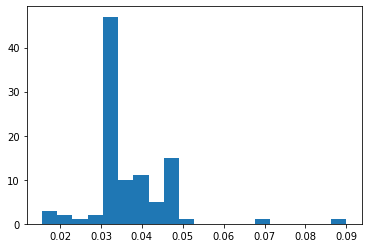

In [84]:
R = np.array(Resultados["sha256"]["gen"])
plt.hist(R[R<.150], bins=20)

In [149]:
import numpy as np

In [217]:
for n in [1,3,5,7,9,11,13,15,17]:
    print(f"Para {n}")
    print()
    for k in range(1,20):
        mod = 2**k
        #print(f"Para 2^{k}")
        g = []
        for i in range(1000):
            #print((n**i)%mod)
            g.append((n**i)%mod)
        print(k,"-",np.unique(g).shape[0])
    print("------------")

Para 1

1 - 1
2 - 1
3 - 1
4 - 1
5 - 1
6 - 1
7 - 1
8 - 1
9 - 1
10 - 1
11 - 1
12 - 1
13 - 1
14 - 1
15 - 1
16 - 1
17 - 1
18 - 1
19 - 1
------------
Para 3

1 - 1
2 - 2
3 - 2
4 - 4
5 - 8
6 - 16
7 - 32
8 - 64
9 - 128
10 - 256
11 - 512
12 - 1000
13 - 1000
14 - 1000
15 - 1000
16 - 1000
17 - 1000
18 - 1000
19 - 1000
------------
Para 5

1 - 1
2 - 1
3 - 2
4 - 4
5 - 8
6 - 16
7 - 32
8 - 64
9 - 128
10 - 256
11 - 512
12 - 1000
13 - 1000
14 - 1000
15 - 1000
16 - 1000
17 - 1000
18 - 1000
19 - 1000
------------
Para 7

1 - 1
2 - 2
3 - 2
4 - 2
5 - 4
6 - 8
7 - 16
8 - 32
9 - 64
10 - 128
11 - 256
12 - 512
13 - 1000
14 - 1000
15 - 1000
16 - 1000
17 - 1000
18 - 1000
19 - 1000
------------
Para 9

1 - 1
2 - 1
3 - 1
4 - 2
5 - 4
6 - 8
7 - 16
8 - 32
9 - 64
10 - 128
11 - 256
12 - 512
13 - 1000
14 - 1000
15 - 1000
16 - 1000
17 - 1000
18 - 1000
19 - 1000
------------
Para 11

1 - 1
2 - 2
3 - 2
4 - 4
5 - 8
6 - 16
7 - 32
8 - 64
9 - 128
10 - 256
11 - 512
12 - 1000
13 - 1000
14 - 1000
15 - 1000
16 - 1000
17 - 1000
18 

In [129]:

for k in range(1,10):
    print("----------------------------")
    U_2_k = np.array([2*m -1 for m in range(1,2**(k)) if 2*m -1 < 2**k])
    print(f"U(2^{k}) tiene orden {2**(k-1)}")
    for a in range(len(U_2_k)):
        for h in range(1,1000):
            if (U_2_k[a]**h % (2**k)) == 1:
                break
        if h == 2:
            print(f"Orden de {U_2_k[a]} - {h} - pos: {a}")
    print("----------------------------")

----------------------------
U(2^1) tiene orden 1
----------------------------
----------------------------
U(2^2) tiene orden 2
Orden de 3 - 2 - pos: 1
----------------------------
----------------------------
U(2^3) tiene orden 4
Orden de 3 - 2 - pos: 1
Orden de 5 - 2 - pos: 2
Orden de 7 - 2 - pos: 3
----------------------------
----------------------------
U(2^4) tiene orden 8
Orden de 7 - 2 - pos: 3
Orden de 9 - 2 - pos: 4
Orden de 15 - 2 - pos: 7
----------------------------
----------------------------
U(2^5) tiene orden 16
Orden de 15 - 2 - pos: 7
Orden de 17 - 2 - pos: 8
Orden de 31 - 2 - pos: 15
----------------------------
----------------------------
U(2^6) tiene orden 32
Orden de 31 - 2 - pos: 15
Orden de 33 - 2 - pos: 16
Orden de 63 - 2 - pos: 31
----------------------------
----------------------------
U(2^7) tiene orden 64
Orden de 63 - 2 - pos: 31
Orden de 65 - 2 - pos: 32
Orden de 127 - 2 - pos: 63
----------------------------
----------------------------
U(2^8) tiene 

In [16]:
Resultados_std

{'sha1': {'cert': 0.2650851657320156,
  'gen': 0.008304986104541891,
  'ver': 0.004248903744245053},
 'sha224': {'cert': 0.3714838680662022,
  'gen': 0.018236669524859476,
  'ver': 0.006133635989783843},
 'sha256': {'cert': 0.39454282431209037,
  'gen': 0.006953478510709615,
  'ver': 0.004702867969079435},
 'sha512': {'cert': 0.34299526505103933,
  'gen': 0.007834494521311132,
  'ver': 0.007465559134669022},
 'sha384': {'cert': 0.36761177811244294,
  'gen': 0.00700709497043051,
  'ver': 0.0051145872753150575}}

In [232]:
508/8

63.5

In [243]:
n = 10282
k = 1
((n - k)**2) % n

1

In [48]:
(9**5)%16

7

In [74]:
g = ['drtyui', 'ghj', 'A01752067']
k = ""
for h in g:
    k+=h+";"

In [78]:
k[:-1]

'drtyui;ghj;A01752067'

In [79]:
f =()

In [82]:
f == ()

True